In [1]:
# This allow jupiter to upload in real time externally modified code
%load_ext autoreload
%autoreload 2 

import sys
sys.path.append("..")
import os

import pandas as pd
import pandas_ta as ta
pd.options.mode.chained_assignment = None  # default='warn'
pd.options.display.float_format = '{:.5f}'.format


import numpy as np
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
from x_CLASSES.download_data import DownloadData
from tabulate import tabulate
import matplotlib.pyplot as plt

# Classify price movements based on candlesticks statistics

This reseach comes from [this](https://www.forexfactory.com/thread/post/14707863#post14707863) post on ForexFactory. 

### Step 1: Calculations

#### Step 1.1: Higher price frame (1k ticks)

In [2]:
class PriceFrame():

    def __init__(self, start_date, end_date, timeframe, price_frame, csv_file_path):    
        self.timeframe = timeframe
        self.price_frame = price_frame
        self.csv_file_path = csv_file_path

        self.start_date = start_date
        self.end_date = end_date

        if self.start_date > self.end_date:
            raise SystemExit(f"Start date can't be after end date.")
        
        self.dataframe, self.avg_oc, self.avg_wk = self.getDataframe()

    def getDataframe(self):
        df = pd.DataFrame()

        if os.path.exists(self.csv_file_path):
            df = pd.read_csv(self.csv_file_path)
        else:
            df = DownloadData('GBP/USD', self.start_date,self.end_date,self.timeframe).getData()
            
            data_folder_path = f"{os.getcwd()}/x_DATA"
            if not os.path.exists(data_folder_path):
                os.makedirs(data_folder_path)

            df.to_csv(self.csv_file_path)

        if "Ask" in df.columns:
            df = df.drop("Ask", axis=1)

        df["Close"] = df["Bid"].copy()
        df["Open"] = df["Bid"].shift(self.price_frame)  # Shift the "Bid" values 1000 rows back
        df["High"] = df["Bid"].rolling(window=self.price_frame).max()  # Calculate the rolling max over the last 1000 rows
        df["Low"] = df["Bid"].rolling(window=self.price_frame).min()  # Calculate the rolling min over the last 1000 rows

        # Calculate the index of the maximum value in the rolling window for "High time"
        #df['High Time'] =  self.price_frame - ( df.index.values - df['Bid'].rolling(window=self.price_frame).agg(lambda x: x.index.values[np.argmax(x.values)]) ) 
        #df["Low Time"] = self.price_frame  - ( df.index.values - df['Bid'].rolling(window=self.price_frame).agg(lambda x: x.index.values[np.argmin(x.values)]) )

        #df['High First'] = df['High Time'] < df["Low Time"]

        df = df.dropna() #Drop initial NaN values

        # DIRECTIONAL BIAS
        df['Open - Close'] = (df['Open'] - df['Close']).abs()
        df['Upper Wick'] = (df['High'] - df[['Open', 'Close']].max(axis=1))
        df['Lower Wick'] = (df[['Open', 'Close']].min(axis=1) - df['Low'])

        df['Bias'] = np.where(df['Open'] > df['Close'], 'Bearish', np.where(df['Close'] > df['Open'], 'Bullish', 'Doji'))
        
        # Filter rows where Bias is "Bullish"
        bullish_rows = df[df['Bias'] == 'Bullish']
        bearish_rows = df[df['Bias'] == 'Bearish']

        # average directional OC
        average_bullish_oc = bullish_rows['Open - Close'].mean()
        average_bearish_oc = bearish_rows['Open - Close'].mean()
        avg_oc = ( average_bullish_oc + average_bearish_oc ) / 2
        
        # average bullish and bearish candle Wick (relative to close)
        average_bullish_upper = bullish_rows['Upper Wick'].mean()
        average_bearish_lower = bearish_rows['Lower Wick'].mean()
        avg_wk = ( average_bullish_upper + average_bearish_lower ) / 2

        # assign strenght bias
        df['Strength'] = np.where(df['Open - Close'] > avg_oc+avg_wk, 'Strong',
                                np.where((df['Open - Close'] > avg_oc) & (df['Open - Close'] <= avg_oc+avg_wk), 'Medium', 'Weak'))
        return df, avg_oc, avg_wk
    
    def printCategories(self):
    
        categories = ['Weak','Medium','Strong']

        thresholds_list = {
            'Thresholds' : categories,
            'Value' : [f'0 - {round(self.avg_oc, 5)}',f'{round(self.avg_oc, 5)} - {round(self.avg_wk+self.avg_oc, 5)}', f'>{round(self.avg_wk+self.avg_oc, 5)}']
        }

        print_ = f'<p style="font-size: 14px;">Categories {self.price_frame}ticks price-frame:</p>'
        display(HTML(print_))
        display(HTML(tabulate(thresholds_list, headers='keys', tablefmt='html', showindex=False, floatfmt=".5f", numalign="center", stralign="center")))

In [3]:
start_date = "01-12-2023"
end_date = "05-01-2024"
timeframe = 'tick'
price_frame = 1000

csv_file_path = f"{os.path.dirname(os.getcwd())}/x_DATA/{start_date}_{end_date}  {timeframe}.csv"

master_dimension = PriceFrame(start_date,end_date,timeframe,price_frame,csv_file_path) # Master dimension = highest one (1000 ticks)

df1k = master_dimension.dataframe[['Timestamp','Bid','Bias']]
display(df1k)
master_dimension.printCategories()

,Timestamp,Bid,Bias
1000,2023-12-01 00:21:58.140000+00:00,1.26378,Bullish
1001,2023-12-01 00:22:00.557000+00:00,1.26377,Bullish
1002,2023-12-01 00:22:00.912000+00:00,1.26378,Bullish
1003,2023-12-01 00:22:01.166000+00:00,1.26378,Bullish
1004,2023-12-01 00:22:01.317000+00:00,1.26378,Bullish
...,...,...,...
2383418,2024-01-04 23:59:36.774000+00:00,1.26810,Bearish
2383419,2024-01-04 23:59:41.153000+00:00,1.26808,Bearish
2383420,2024-01-04 23:59:41.256000+00:00,1.26808,Bearish
2383421,2024-01-04 23:59:55.951000+00:00,1.26805,Bearish


Thresholds,Value
Weak,0 - 0.00046
Medium,0.00046 - 0.00067
Strong,>0.00067


#### Step 1.2: smaller price frame (.25*1k ticks)

In [4]:
price_frame25 = int(1000 * 0.25)

wick_dimension = PriceFrame(start_date,end_date,timeframe,price_frame25,csv_file_path) # Wick dimension = intermediate (1000 * 0.25 ticks)

df25 = wick_dimension.dataframe[['Timestamp','Bid','Bias']]
display(df25)
wick_dimension.printCategories()

,Timestamp,Bid,Bias
250,2023-12-01 00:06:10.974000+00:00,1.26347,Bullish
251,2023-12-01 00:06:11.280000+00:00,1.26347,Bullish
252,2023-12-01 00:06:11.383000+00:00,1.26345,Bullish
253,2023-12-01 00:06:11.537000+00:00,1.26346,Bullish
254,2023-12-01 00:06:11.992000+00:00,1.26345,Bullish
...,...,...,...
2383418,2024-01-04 23:59:36.774000+00:00,1.26810,Bearish
2383419,2024-01-04 23:59:41.153000+00:00,1.26808,Bearish
2383420,2024-01-04 23:59:41.256000+00:00,1.26808,Bearish
2383421,2024-01-04 23:59:55.951000+00:00,1.26805,Bearish


Thresholds,Value
Weak,0 - 0.00023
Medium,0.00023 - 0.00033
Strong,>0.00033


### Step 2: Donchian Channel
I'll create a Donchian channel mid-band with a period of 1000 ticks, because this is the price-frame I want to see. That way I "emulate" a rolling candlestick without the need of a custom chart; a side effect of this method would be a more responsive application of the boundaries, initially all boundaries would be added/subtracted to the 1000th past tick, now they are added/subtracted to the middle of the last 1000ticks range. 

In [5]:
def donchianClasses(data : pd.DataFrame,price_frame : PriceFrame, window_size):
    # Calculate the middle channel (simple moving average of the upper and lower channels)
    data['MiddleChannel'] = ( data['Bid'].rolling(window=window_size).max() + data['Bid'].rolling(window=window_size).min() ) / 2
    
    data['WeakUp'] = data['MiddleChannel'] + ( price_frame.avg_oc /2 ) 
    data['WeakDown'] = data['MiddleChannel'] - ( price_frame.avg_oc /2 ) 

    data['MediumUp'] = data['WeakUp'] + price_frame.avg_wk
    data['MediumDown'] = data['WeakDown'] - price_frame.avg_wk

    # Bias for DC channel: a candle is Bullish if above the middle line
    data['BiasDC'] = np.where(data['Bid'] > data['MiddleChannel'], 'Bullish', np.where(data['Bid'] < data['MiddleChannel'], 'Bearish', 'Doji'))
    # Strenght classification of each tick
    data['StrengthDC'] = np.where(
        (data['Bid'] > data['MediumUp']) | (data['Bid'] < data['MediumDown']), 'Strong',
        np.where(
            ((data['Bid'] <= data['MediumUp']) & (data['Bid'] > data['WeakUp'])) |
            ((data['Bid'] < data['WeakDown']) & (data['Bid'] >= data['MediumDown'])), 'Medium', 'Weak'
    )
)
    return data

df1k = donchianClasses(df1k,master_dimension,price_frame)
df1k = df1k.dropna() #Drop initial NaN values
display(df1k)

df25 = donchianClasses(df25,wick_dimension,price_frame25)
df25 = df25.dropna() #Drop initial NaN values
display(df25)

,Timestamp,Bid,Bias,MiddleChannel,WeakUp,WeakDown,MediumUp,MediumDown,BiasDC,StrengthDC
1999,2023-12-01 00:43:00.300000+00:00,1.26398,Bullish,1.26394,1.26417,1.26371,1.26439,1.26349,Bullish,Weak
2000,2023-12-01 00:43:00.602000+00:00,1.26398,Bullish,1.26394,1.26417,1.26371,1.26439,1.26349,Bullish,Weak
2001,2023-12-01 00:43:01.108000+00:00,1.26398,Bullish,1.26394,1.26417,1.26371,1.26439,1.26349,Bullish,Weak
2002,2023-12-01 00:43:01.312000+00:00,1.26398,Bullish,1.26394,1.26417,1.26371,1.26439,1.26349,Bullish,Weak
2003,2023-12-01 00:43:02.070000+00:00,1.26399,Bullish,1.26394,1.26417,1.26371,1.26439,1.26349,Bullish,Weak
...,...,...,...,...,...,...,...,...,...,...
2383418,2024-01-04 23:59:36.774000+00:00,1.26810,Bearish,1.26825,1.26848,1.26803,1.26870,1.26781,Bearish,Weak
2383419,2024-01-04 23:59:41.153000+00:00,1.26808,Bearish,1.26825,1.26848,1.26803,1.26870,1.26781,Bearish,Weak
2383420,2024-01-04 23:59:41.256000+00:00,1.26808,Bearish,1.26825,1.26848,1.26803,1.26870,1.26781,Bearish,Weak
2383421,2024-01-04 23:59:55.951000+00:00,1.26805,Bearish,1.26825,1.26848,1.26803,1.26870,1.26781,Bearish,Weak


,Timestamp,Bid,Bias,MiddleChannel,WeakUp,WeakDown,MediumUp,MediumDown,BiasDC,StrengthDC
499,2023-12-01 00:10:37.627000+00:00,1.26367,Bullish,1.26348,1.26360,1.26336,1.26369,1.26327,Bullish,Medium
500,2023-12-01 00:10:37.981000+00:00,1.26367,Bullish,1.26348,1.26360,1.26336,1.26369,1.26327,Bullish,Medium
501,2023-12-01 00:10:39.801000+00:00,1.26367,Bullish,1.26348,1.26360,1.26336,1.26369,1.26327,Bullish,Medium
502,2023-12-01 00:10:39.903000+00:00,1.26368,Bullish,1.26348,1.26360,1.26336,1.26369,1.26327,Bullish,Medium
503,2023-12-01 00:10:40.056000+00:00,1.26367,Bullish,1.26348,1.26360,1.26336,1.26369,1.26327,Bullish,Medium
...,...,...,...,...,...,...,...,...,...,...
2383418,2024-01-04 23:59:36.774000+00:00,1.26810,Bearish,1.26818,1.26829,1.26806,1.26839,1.26796,Bearish,Weak
2383419,2024-01-04 23:59:41.153000+00:00,1.26808,Bearish,1.26818,1.26829,1.26806,1.26839,1.26796,Bearish,Weak
2383420,2024-01-04 23:59:41.256000+00:00,1.26808,Bearish,1.26818,1.26829,1.26806,1.26839,1.26796,Bearish,Weak
2383421,2024-01-04 23:59:55.951000+00:00,1.26805,Bearish,1.26818,1.26829,1.26806,1.26839,1.26796,Bearish,Medium


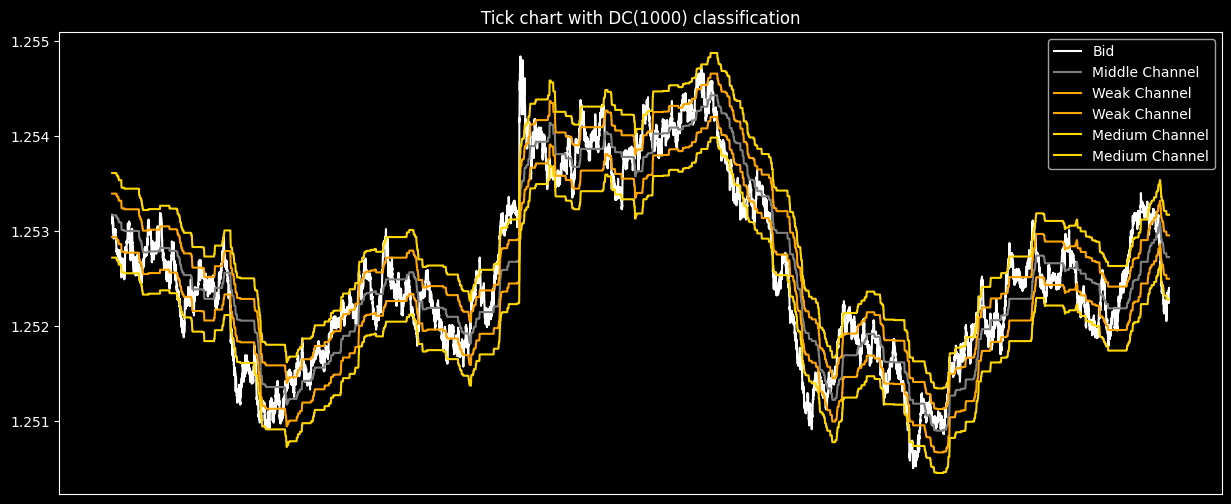

In [6]:
# Filter the DataFrame for the specified time range
df_window = df1k[(df1k['Timestamp'] >= '2023-12-13 09:00:00') & (df1k['Timestamp'] <= '2023-12-13 17:00:00')].copy()

plt.style.use('dark_background')
fig, ax = plt.subplots(figsize=(15, 6))
ax.plot(df_window['Bid'], color='white', label='Bid')
ax.plot(df_window['MiddleChannel'], color='gray', label='Middle Channel')
ax.plot(df_window[['WeakUp','WeakDown']], color='orange', label='Weak Channel')
ax.plot(df_window[['MediumUp','MediumDown']], color='gold', label='Medium Channel')

ax.set(title='Tick chart with DC(1000) classification')
ax.xaxis.set_tick_params(labelbottom=False)
ax.get_xaxis().set_ticks([])

ax.legend()

plt.show()

### Step 3: Statistics
Collecting the same kind of statistics as before, but extrapolating them from the DonchianChannel, treating every single tick as a rolling candle. The average directional candlestick is projected on the channels. 

In [7]:
def getStatistics(df,price_frame):
    html = ""
    
    # Possible values in each column
    unique_biases = ['Bullish','Bearish','Doji'] 
    unique_strengthes = ['Subset','All']#,'Weak','Medium','Strong']

    #pd.options.display.float_format = '{:.5f}'.format
    biases_data = [
        #("sample size"),
        ("sample size"),
        ("% inside weak channel"),
        ("% inside medium channel"),
        ("% in strong area")
    ]

    html+= f'<p style="font-size: 24px;">{price_frame} tick dimension</p>'

    for bias in unique_biases:
        html+= "<hr>"
        html+= f'<p style="color:{"green" if bias == "Bullish" else "red" if bias == "Bearish" else "orange"}; font-size: 24px;">{bias}</p>'
        #display(HTML(print_))
        
        biases_df = pd.DataFrame(biases_data, columns=[f'{bias}'])

        html+= "<hr>"
        info_high = 'Irrespective of High being before or after Low'
        html+=  f'<p style="color:{"green" if bias == "Bullish" else "red" if bias == "Bearish" else "orange"}; font-size: 16px;">{info_high}</p>' 
            #display(HTML(print_))

        for strength in unique_strengthes:
        
            
        
            if strength == 'All':
                subset = df
            else:
                subset = df[df['BiasDC'] == bias]

            sample = ( subset.size / df.size ) *100 # This is the % of occurrences

            # % Inside channels
            mean_weak = ( (subset['Bias'] == bias) & (subset['Bid'] <= subset['WeakUp']) & (subset['Bid'] >= subset['WeakDown'])).mean() * 100

            mean_medium = ( (subset['Bias'] == bias) & ( ( (subset['Bid'] > subset['WeakUp']) & (subset['Bid'] <= subset['MediumUp']) ) |
                                ( (subset['Bid'] < subset['WeakDown']) & (subset['Bid'] >= subset['MediumDown']) ) )).mean() * 100
            
            mean_strong = ( (subset['Bias'] == bias) & ( (subset['Bid'] > subset['MediumUp']) | (subset['Bid'] < subset['MediumDown'] ) ) ).mean() * 100
            
            biases_df[strength] = [
                f'{int(sample)}%' if not np.isnan(sample) else 0,
                f'{int(mean_weak)}%' if not np.isnan(sample) else 0,
                f'{int(mean_medium)}%' if not np.isnan(sample) else 0,
                f'{int(mean_strong)}%' if not np.isnan(sample) else 0
            ]
        
        html+=  tabulate(biases_df, headers='keys', tablefmt='html', floatfmt=".6f",showindex=False, numalign="center", stralign="right")
    
    return html


# Two sets of HTML outputs
first_html = f'<div style="margin-right:20px;">{getStatistics(df1k,master_dimension.price_frame) }</div>'  # Replace '...' with your first HTML
second_html = f'<div style="margin-right:20px;">{getStatistics(df25,wick_dimension.price_frame)}</div>'  # Replace '...' with your second HTML

# Concatenate the HTML strings and add the clear:both style
all_html = f'<div style="float:left;">{first_html}</div><div style="float:left;">{second_html}</div><div style="clear:both;"></div>'

# Display the concatenated HTML strings
display(HTML(all_html))

Bullish,Subset,All
sample size,50%,100%
% inside weak channel,38%,26%
% inside medium channel,29%,15%
% in strong area,16%,8%
Bearish,Subset,All
sample size,49%,100%
% inside weak channel,38%,26%
% inside medium channel,29%,15%
% in strong area,16%,8%
Doji,Subset,All


### Step 4: A slighlty different approach
Donchian Channel is certainly better than having to plot a rolling candlestick chart, but I wonder if it can be better.

Here I try to create a separate window indicator which is basically the donchian but seen from another perspective: the main line is Close - MiddleDC, so that I obtain a value that oscillates around 0, basically just like a MACD. Then all the horizontal lines are just the levels. 

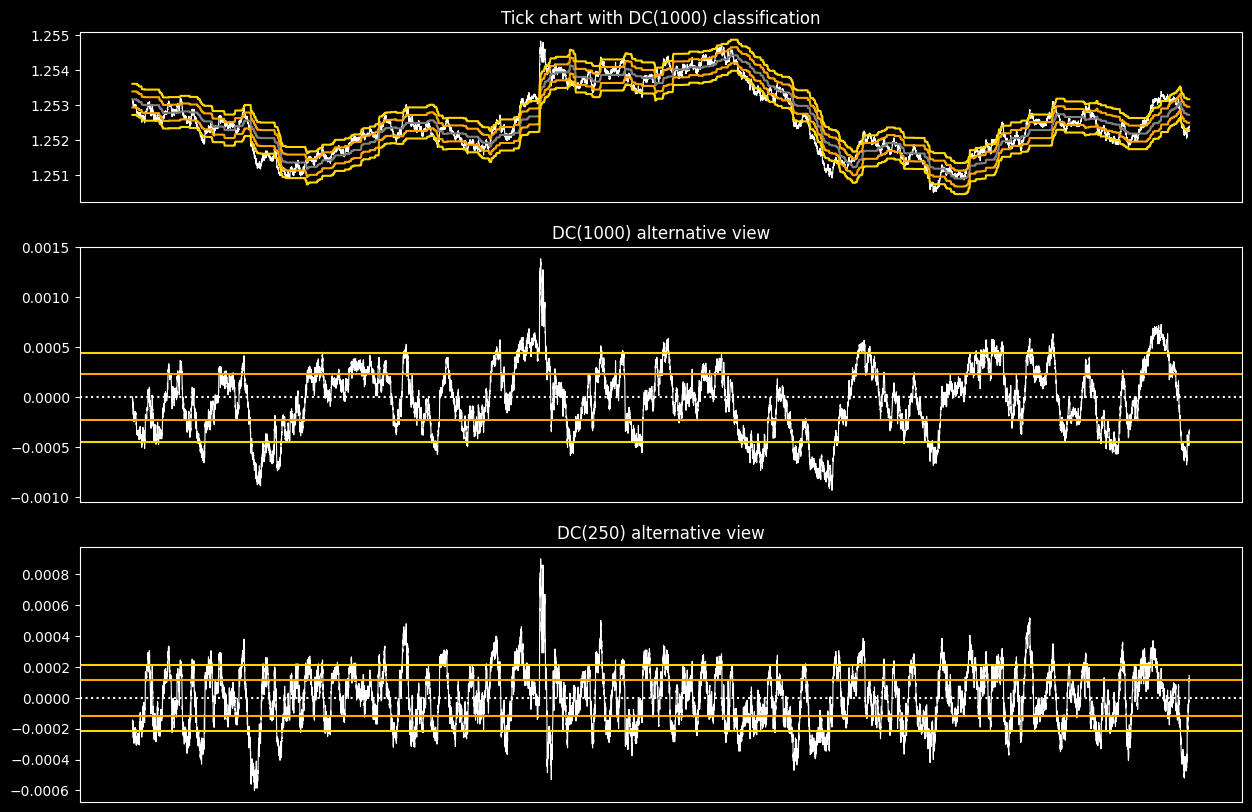

In [8]:
df1k['SeparateDC'] = df1k['Bid'] - df1k['MiddleChannel']
df25['SeparateDC'] = df25['Bid'] - df25['MiddleChannel']

df_window = df1k[(df1k['Timestamp'] >= '2023-12-13 09:00:00') & (df1k['Timestamp'] <= '2023-12-13 17:00:00')].copy()
df_window25 = df25[(df25['Timestamp'] >= '2023-12-13 09:00:00') & (df25['Timestamp'] <= '2023-12-13 17:00:00')].copy()

plt.style.use('dark_background')
#fig, ax = plt.subplots(figsize=(15, 6))
#fig, (ax1, ax2) = plt.subplots(3, 1, gridspec_kw={'height_ratios': [3,1,1]}, sharex=True, figsize=(15, 6))
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, gridspec_kw={'height_ratios': [2, 3, 3]}, sharex=True, figsize=(15, 10))

ax1.plot(df_window['Bid'], color='white',linewidth=.8, label='Bid')
ax1.plot(df_window['MiddleChannel'], color='gray', label='Middle Channel')
ax1.plot(df_window[['WeakUp','WeakDown']], color='orange', label='Weak Channel')
ax1.plot(df_window[['MediumUp','MediumDown']], color='gold', label='Medium Channel')

ax1.set(title='Tick chart with DC(1000) classification')
ax1.xaxis.set_tick_params(labelbottom=False)
ax1.get_xaxis().set_ticks([])

ax2.set(title='DC(1000) alternative view')
ax2.plot(df_window['SeparateDC'],color='white',linewidth=.8)#, label='Alternative view')
ax2.axhline(0, color='white', linestyle='dotted', label='Medium Channel')
ax2.axhline(-(master_dimension.avg_oc/2)-master_dimension.avg_wk, color='gold', linestyle='-', label='Medium Channel')
ax2.axhline((master_dimension.avg_oc/2)+master_dimension.avg_wk, color='gold', linestyle='-', label='Medium Channel')
ax2.axhline((master_dimension.avg_oc/2), color='orange', linestyle='-', label='Weak Channel')
ax2.axhline(-(master_dimension.avg_oc/2), color='orange', linestyle='-', label='Weak Channel')

ax3.set(title='DC(250) alternative view')
ax3.plot(df_window25['SeparateDC'],color='white',linewidth=.8)#, label='Alternative view')
ax3.axhline(0, color='white', linestyle='dotted', label='Medium Channel')
ax3.axhline(-(wick_dimension.avg_oc/2)-wick_dimension.avg_wk, color='gold', linestyle='-', label='Medium Channel')
ax3.axhline((wick_dimension.avg_oc/2)+wick_dimension.avg_wk, color='gold', linestyle='-', label='Medium Channel')
ax3.axhline((wick_dimension.avg_oc/2), color='orange', linestyle='-', label='Weak Channel')
ax3.axhline(-(wick_dimension.avg_oc/2), color='orange', linestyle='-', label='Weak Channel')


#ax1.legend()
#ax2.legend()

plt.show()


In [9]:
df25 = df25.add_suffix("_25")
df25.rename(columns={'Timestamp_25': 'Timestamp'}, inplace=True)
df25

df1k = pd.merge(df1k, df25[['Timestamp', 'Bias_25', 'MiddleChannel_25', 'WeakUp_25', 'WeakDown_25',
                            'MediumUp_25', 'MediumDown_25', 'BiasDC_25', 'StrengthDC_25', 'SeparateDC_25']], on='Timestamp')
del df25

df1k

,Timestamp,Bid,Bias,MiddleChannel,WeakUp,WeakDown,MediumUp,MediumDown,BiasDC,StrengthDC,SeparateDC,Bias_25,MiddleChannel_25,WeakUp_25,WeakDown_25,MediumUp_25,MediumDown_25,BiasDC_25,StrengthDC_25,SeparateDC_25
0,2023-12-01 00:43:00.300000+00:00,1.26398,Bullish,1.26394,1.26417,1.26371,1.26439,1.26349,Bullish,Weak,0.00004,Bullish,1.26389,1.26401,1.26377,1.26410,1.26368,Bullish,Weak,0.00009
1,2023-12-01 00:43:00.602000+00:00,1.26398,Bullish,1.26394,1.26417,1.26371,1.26439,1.26349,Bullish,Weak,0.00004,Bullish,1.26389,1.26401,1.26377,1.26410,1.26368,Bullish,Weak,0.00009
2,2023-12-01 00:43:01.108000+00:00,1.26398,Bullish,1.26394,1.26417,1.26371,1.26439,1.26349,Bullish,Weak,0.00004,Bullish,1.26389,1.26401,1.26377,1.26410,1.26368,Bullish,Weak,0.00009
3,2023-12-01 00:43:01.312000+00:00,1.26398,Bullish,1.26394,1.26417,1.26371,1.26439,1.26349,Bullish,Weak,0.00004,Bullish,1.26389,1.26401,1.26377,1.26410,1.26368,Bullish,Weak,0.00009
4,2023-12-01 00:43:02.070000+00:00,1.26399,Bullish,1.26394,1.26417,1.26371,1.26439,1.26349,Bullish,Weak,0.00005,Bullish,1.26389,1.26401,1.26377,1.26410,1.26368,Bullish,Weak,0.00010
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2381419,2024-01-04 23:59:36.774000+00:00,1.26810,Bearish,1.26825,1.26848,1.26803,1.26870,1.26781,Bearish,Weak,-0.00015,Bearish,1.26818,1.26829,1.26806,1.26839,1.26796,Bearish,Weak,-0.00008
2381420,2024-01-04 23:59:41.153000+00:00,1.26808,Bearish,1.26825,1.26848,1.26803,1.26870,1.26781,Bearish,Weak,-0.00017,Bearish,1.26818,1.26829,1.26806,1.26839,1.26796,Bearish,Weak,-0.00009
2381421,2024-01-04 23:59:41.256000+00:00,1.26808,Bearish,1.26825,1.26848,1.26803,1.26870,1.26781,Bearish,Weak,-0.00017,Bearish,1.26818,1.26829,1.26806,1.26839,1.26796,Bearish,Weak,-0.00009
2381422,2024-01-04 23:59:55.951000+00:00,1.26805,Bearish,1.26825,1.26848,1.26803,1.26870,1.26781,Bearish,Weak,-0.00021,Bearish,1.26818,1.26829,1.26806,1.26839,1.26796,Bearish,Medium,-0.00013


### Step 5: All possible configurations and their probability distribution

In [10]:
# Possible values in each column
unique_biases = ['Bullish','Bearish']
unique_biases_25 = ['Bullish','Bearish']
unique_strengthes = ['Weak','Medium','Strong']
unique_strengthes_25= ['Weak','Medium','Strong']

columns = [f'{master_dimension.price_frame}tick',f'{wick_dimension.price_frame}tick','Occurrence']

combinations = pd.DataFrame(columns=columns)
sum = 0

for bias in unique_biases:
    for strength in unique_strengthes:
        for bias_25 in unique_biases_25:
                for strength_25 in unique_strengthes_25:
                    
                    occurrence = ( (df1k['BiasDC'] == bias) & (df1k['StrengthDC'] == strength) & 
                                  (df1k['BiasDC_25']==bias_25) & (df1k['StrengthDC_25']==strength_25)).mean() * 100
                    sum += occurrence
                    new_row = {
                         columns[0] : f'{bias} - {strength}',
                         columns[1] : f'{bias_25} - {strength_25}',
                         columns[2] : f'{int(occurrence)}%' if not np.isnan(occurrence) else 0,
                    }

                    # Append the new row to the DataFrame
                    combinations = pd.concat([combinations,pd.DataFrame([new_row])], ignore_index=True)

#tabulate(biases_df, headers='keys', tablefmt='html', floatfmt=".6f",showindex=False, numalign="center", stralign="right")               
    
display(combinations)


print(f'Sum={round(sum,2)}%')


,1000tick,250tick,Occurrence
0,Bullish - Weak,Bullish - Weak,10%
1,Bullish - Weak,Bullish - Medium,4%
2,Bullish - Weak,Bullish - Strong,1%
3,Bullish - Weak,Bearish - Weak,7%
4,Bullish - Weak,Bearish - Medium,1%
5,Bullish - Weak,Bearish - Strong,0%
6,Bullish - Medium,Bullish - Weak,5%
7,Bullish - Medium,Bullish - Medium,4%
8,Bullish - Medium,Bullish - Strong,3%
9,Bullish - Medium,Bearish - Weak,2%


Sum=98.56%


### Step 6: Probability transition matrix

#### How to read the table
If you take, for example the first value, $ $, you read it like that:
- The probability of price changing from "category on row1" to "category on column 1" on the next 10 ticks is: $ $

> I choose 10 ticks because counting for every single tick would be useless. Probably even 10 is just to small. 

To donwload the table in a csv format click [here](transition_matrix.csv).

In [18]:
transition = pd.DataFrame(columns=['Index'])
sum = 0

for bias in unique_biases:
    for strength in unique_strengthes:
        for bias_25 in unique_biases_25:
                for strength_25 in unique_strengthes_25:
                    category = f'\\t {master_dimension.price_frame}: {bias} {strength} \\n {wick_dimension.price_frame}: {bias_25} - {strength_25}'
                    #new_row = {'Index' : category}
                    # Append the new row to the DataFrame
                    #transition = pd.concat([transition,pd.DataFrame([new_row])],ignore_index=True)
                    transition.loc[sum,'Index']=category
                    sum2=0
                    check = 0
                    for bias2 in unique_biases:
                        for strength2 in unique_strengthes:  
                            for bias_25_2 in unique_biases_25:
                                    for strength_25_2 in unique_strengthes_25:
                                        category2 = f'\\t {master_dimension.price_frame}: {bias2} {strength2} \\n {wick_dimension.price_frame}: {bias_25_2} - {strength_25_2}'
                                        
                                        category_df = ( (df1k['BiasDC'] == bias) & (df1k['StrengthDC'] == strength) &
                                            (df1k['BiasDC_25'] == bias_25) & (df1k['StrengthDC_25'] == strength_25) )

                                        condition_df = ( (df1k['BiasDC'].shift(-10) == bias2) & (df1k['StrengthDC'].shift(-10) == strength2) 
                                                        & (df1k['BiasDC_25'].shift(-10) == bias_25_2) 
                                                        & (df1k['StrengthDC_25'].shift(-10) == strength_25_2) ) 

                                        probability = ( (category_df & condition_df).mean() / category_df.mean() ) * 100

                                        """ OLD CODE - using conditional probability seems to work better and faster
                                        probability = (  (  ( df1k['BiasDC'] == bias ) & ( df1k['BiasDC'].shift(-10) == bias2 ) &
                                                         ( df1k['StrengthDC'] == strength ) & ( df1k['StrengthDC'].shift(-10) == strength2 ) &
                                                         ( df1k['BiasDC_25'] == bias_25 ) & ( df1k['BiasDC_25'].shift(-10) == bias_25_2 ) &
                                                         ( df1k['StrengthDC_25'] == strength_25 ) & ( df1k['StrengthDC_25'].shift(-10) == strength_25_2 )
                                         ).mean() / ((df1k['BiasDC'] == bias) &
                                                    (df1k['StrengthDC'] == strength) &
                                                    (df1k['BiasDC_25'] == bias_25) &
                                                    (df1k['StrengthDC_25'] == strength_25) ).mean() ) *100
                                        """
                                        print(f'\r \t Calculating cell:{sum}x{sum2} '
                                            f'Transition probability: {round(probability,2)}% ', end='', flush=True)
                                        
                                        sum2+= 1
                                        check += probability
                                        transition.loc[sum,category2]= f'{round(probability,2)}%' if not np.isnan(probability) else 0
                    transition.loc[sum,'Check \n (sum of row)']= f'{round(check,2)}'
                    sum+= 1

                                        
print('\r' + ' ' * 80, end='\r', flush=True)

transition.to_csv('transition_matrix.csv')
display( HTML( transition.to_html().replace("\\n","</nobr><br><nobr>").replace("\\t","<nobr>") ) )

,Index,1000: Bullish Weak 250: Bullish - Weak,1000: Bullish Weak 250: Bullish - Medium,1000: Bullish Weak 250: Bullish - Strong,1000: Bullish Weak 250: Bearish - Weak,1000: Bullish Weak 250: Bearish - Medium,1000: Bullish Weak 250: Bearish - Strong,1000: Bullish Medium 250: Bullish - Weak,1000: Bullish Medium 250: Bullish - Medium,1000: Bullish Medium 250: Bullish - Strong,1000: Bullish Medium 250: Bearish - Weak,1000: Bullish Medium 250: Bearish - Medium,1000: Bullish Medium 250: Bearish - Strong,1000: Bullish Strong 250: Bullish - Weak,1000: Bullish Strong 250: Bullish - Medium,1000: Bullish Strong 250: Bullish - Strong,1000: Bullish Strong 250: Bearish - Weak,1000: Bullish Strong 250: Bearish - Medium,1000: Bullish Strong 250: Bearish - Strong,1000: Bearish Weak 250: Bullish - Weak,1000: Bearish Weak 250: Bullish - Medium,1000: Bearish Weak 250: Bullish - Strong,1000: Bearish Weak 250: Bearish - Weak,1000: Bearish Weak 250: Bearish - Medium,1000: Bearish Weak 250: Bearish - Strong,1000: Bearish Medium 250: Bullish - Weak,1000: Bearish Medium 250: Bullish - Medium,1000: Bearish Medium 250: Bullish - Strong,1000: Bearish Medium 250: Bearish - Weak,1000: Bearish Medium 250: Bearish - Medium,1000: Bearish Medium 250: Bearish - Strong,1000: Bearish Strong 250: Bullish - Weak,1000: Bearish Strong 250: Bullish - Medium,1000: Bearish Strong 250: Bullish - Strong,1000: Bearish Strong 250: Bearish - Weak,1000: Bearish Strong 250: Bearish - Medium,1000: Bearish Strong 250: Bearish - Strong,Check (sum of row)
0,1000: Bullish Weak 250: Bullish - Weak,0.65%,0.08%,0.0%,0.1%,0.0%,0.0%,0.03%,0.03%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.03%,0.0%,0.0%,0.04%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.98
1,1000: Bullish Weak 250: Bullish - Medium,0.2%,0.55%,0.07%,0.0%,0.0%,0.0%,0.0%,0.05%,0.05%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.05%,0.01%,0.0%,0.01%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.99
2,1000: Bullish Weak 250: Bullish - Strong,0.01%,0.2%,0.56%,0.0%,0.0%,0.0%,0.0%,0.0%,0.15%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.01%,0.04%,0.02%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.99
3,1000: Bullish Weak 250: Bearish - Weak,0.13%,0.0%,0.0%,0.62%,0.07%,0.0%,0.03%,0.0%,0.0%,0.02%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.05%,0.04%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.97
4,1000: Bullish Weak 250: Bearish - Medium,0.0%,0.0%,0.0%,0.23%,0.49%,0.06%,0.01%,0.0%,0.0%,0.05%,0.01%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.08%,0.06%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.99
5,1000: Bullish Weak 250: Bearish - Strong,0.0%,0.0%,0.0%,0.02%,0.2%,0.52%,0.0%,0.0%,0.0%,0.02%,0.03%,0.02%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.18%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.99
6,1000: Bullish Medium 250: Bullish - Weak,0.07%,0.0%,0.0%,0.06%,0.0%,0.0%,0.6%,0.12%,0.0%,0.08%,0.0%,0.0%,0.02%,0.03%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.99
7,1000: Bullish Medium 250: Bullish - Medium,0.08%,0.03%,0.0%,0.01%,0.0%,0.0%,0.16%,0.56%,0.1%,0.0%,0.0%,0.0%,0.0%,0.03%,0.03%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,1.0
8,1000: Bullish Medium 250: Bullish - Strong,0.02%,0.05%,0.02%,0.0%,0.0%,0.0%,0.01%,0.15%,0.66%,0.0%,0.0%,0.0%,0.0%,0.0%,0.08%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,1.0
9,1000: Bullish Medium 250: Bearish - Weak,0.0%,0.0%,0.0%,0.08%,0.07%,0.01%,0.16%,0.0%,0.0%,0.54%,0.07%,0.0%,0.03%,0.01%,0.0%,0.01%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.99
